<a href="https://colab.research.google.com/github/harshithaobulasetty/LSTMTimeSeriesForecasting/blob/main/harshitha_tsla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/5
151/151 - 6s - loss: 0.0659 - val_loss: 0.0415 - 6s/epoch - 39ms/step
Epoch 2/5
151/151 - 1s - loss: 0.0142 - val_loss: 0.0155 - 791ms/epoch - 5ms/step
Epoch 3/5
151/151 - 1s - loss: 0.0052 - val_loss: 0.0027 - 899ms/epoch - 6ms/step
Epoch 4/5
151/151 - 1s - loss: 0.0019 - val_loss: 0.0030 - 953ms/epoch - 6ms/step
Epoch 5/5
151/151 - 1s - loss: 0.0016 - val_loss: 0.0034 - 822ms/epoch - 5ms/step
2/2 [==============================] - 0s 10ms/step
Train RMSE: 5.83
Validation RMSE: 8.91
Test RMSE: 9.80


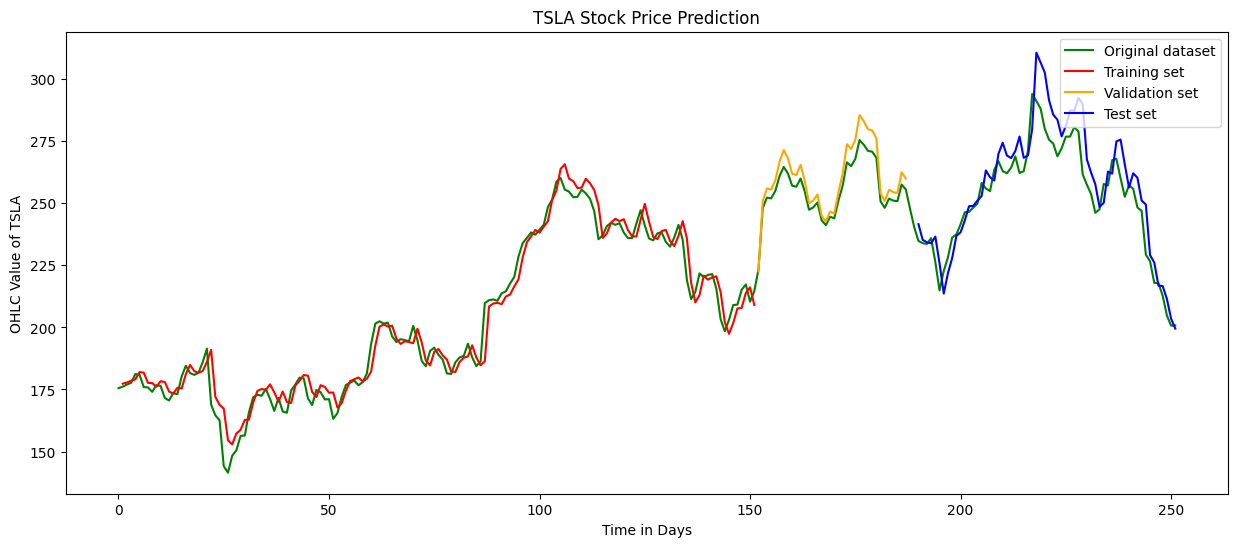

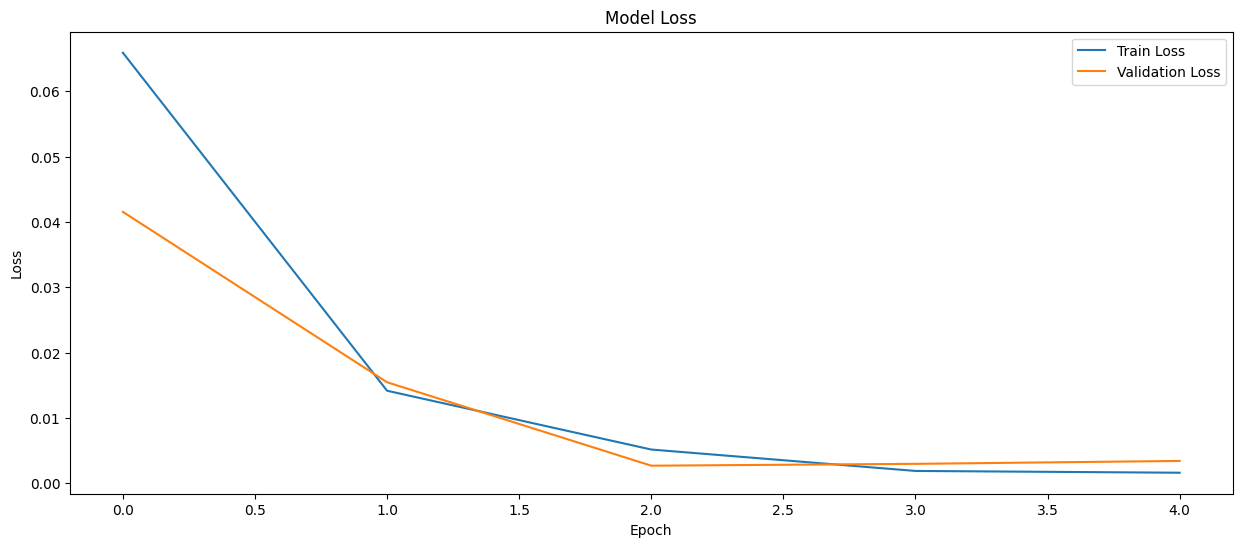

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import math
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(7)

# Load and preprocess dataset
dataset = pd.read_csv('/content/TSLA.csv', usecols=[1,2,3,4])
dataset = dataset.iloc[::-1]  # Reverse the dataset

# Calculate OHLC average
OHLC_avg = dataset.mean(axis=1).values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg_scaled = scaler.fit_transform(OHLC_avg)

# Split into training, validation, and test sets
train_size = int(len(OHLC_avg_scaled) * 0.75)
val_size = int(train_size * 0.2)
train, val, test = OHLC_avg_scaled[:train_size-val_size], OHLC_avg_scaled[train_size-val_size:train_size], OHLC_avg_scaled[train_size:]

# Function to create dataset for LSTM
def create_dataset(data, step_size=1):
    X, Y = [], []
    for i in range(len(data) - step_size):
        X.append(data[i:(i + step_size), 0])
        Y.append(data[i + step_size, 0])
    return np.array(X), np.array(Y)

step_size = 1
trainX, trainY = create_dataset(train, step_size)
valX, valY = create_dataset(val, step_size)
testX, testY = create_dataset(test, step_size)

# Reshape input to be [samples, time steps, features]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
valX = valX.reshape((valX.shape[0], 1, valX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))

# Build and train LSTM model
model = Sequential()
model.add(Input(shape=(1, step_size)))  # Define the input shape using Input layer
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_data=(valX, valY))

# Make predictions
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform(valY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate RMSE
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
valScore = math.sqrt(mean_squared_error(valY, valPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print(f'Train RMSE: {trainScore:.2f}')
print(f'Validation RMSE: {valScore:.2f}')
print(f'Test RMSE: {testScore:.2f}')

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(OHLC_avg_scaled), 'g', label='Original dataset')
plt.plot(np.append([np.nan]*(step_size), trainPredict), 'r', label='Training set')
plt.plot(np.append([np.nan]*(len(trainPredict) + step_size), valPredict), 'orange', label='Validation set')
plt.plot(np.append([np.nan]*(len(trainPredict) + len(valPredict) + 2 * step_size + 1), testPredict), 'b', label='Test set')
plt.legend(loc='upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of TSLA')
plt.title('TSLA Stock Price Prediction')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
